In [2]:
import pandas as pd
import os
from PIL import Image
import numpy as np
from numpy import save, load
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, \
    GlobalMaxPool2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import backend as K


from tqdm import tqdm
from collections import Counter

Using TensorFlow backend.


In [3]:
def read_and_resize(filepath, input_shape=(256, 256)):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)
    im_array = np.array(im, dtype="uint8")#[..., ::-1]
    return np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")

In [4]:
datagen = ImageDataGenerator(
    rotation_range=6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1)

In [5]:
def augment(im_array):
    im_array = datagen.random_transform(im_array)
    return im_array

In [6]:
def gen(df, batch_size=8, aug=False):
    df = df.sample(frac=1)

#     dict_age = {'(0, 2)' : 0,
#                 '(4, 6)' : 1,
#                 '(8, 12)' : 2,
#                 '(15, 20)' : 3,
#                 '(25, 32)' : 4,
#                 '(38, 43)' : 5,
#                 '(48, 53)' : 6,
#                 '(60, 100)' : 7}

    while True:
        for i, batch in enumerate([df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]):
            if aug:
                images = np.array([augment(read_and_resize(file_path)) for file_path in batch.path.values])
            else:
                images = np.array([read_and_resize(file_path) for file_path in batch.path.values])


            labels = np.array([int(g=="m") for g in batch.gender.values])
            labels = labels[..., np.newaxis]

            yield images, labels

In [7]:
def get_model(n_classes=1):

    base_model = ResNet50(weights="./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False)

    #for layer in base_model.layers:
    #    layer.trainable = False

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    if n_classes == 1:
        x = Dense(n_classes, activation="sigmoid")(x)
    else:
        x = Dense(n_classes, activation="softmax")(x)

    base_model = Model(base_model.input, x, name="base_model")
    if n_classes == 1:
        base_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer="adam")
    else:
        base_model.compile(loss="sparse_categorical_crossentropy", metrics=['acc'], optimizer="adam")

    return base_model

In [8]:
 if __name__ == "__main__":
    base_path = "./Dataset-copy/"

    dict_age = {'(0, 2)' : 0,
                '(4, 6)' : 1,
                '(8, 12)' : 2,
                '(15, 20)' : 3,
                '(25, 32)' : 4,
                '(38, 43)' : 5,
                '(48, 53)' : 6,
                '(60, 100)' : 7}

    bag = 3

    all_indexes = list(range(5))

    accuracies = []
    print("Reading train and test CSV files ")
    train_df = pd.read_csv("train_gender_filtered_data_with_path.csv")
    test_df = pd.read_csv("test_gender_filtered_data_with_path.csv")
    print("Reading Done.")
    cnt_ave = 0
    predictions = 0
    print("Extracting test labels and test images from files")
    test_images = load("test_images_np.npy")
    test_labels = load("test_gender_labels.npy")
    print("Extracting Done.")
    tr_tr, tr_val = train_test_split(train_df, test_size=0.1,random_state = 100)
    file_path = "test.h5"
    
    print("Generating callback_list")
    
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    early = EarlyStopping(monitor="val_acc", mode="max", patience=10)

    reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=5)

    callbacks_list = [checkpoint, early, reduce_on_plateau]  # early
    print("Done Generating callbacklist.")
    print("generating Model")
    model = get_model(n_classes=1)
    print("Done generating model")
    print("Running Fit_generator")
    model.fit_generator(gen(tr_tr, aug=True), 
                        validation_data=gen(tr_val), 
                        epochs=200, 
                        verbose=1, 
                        #workers=8,
                        callbacks=callbacks_list,
                        steps_per_epoch=1700, 
                        validation_steps=400,
                        #use_multiprocessing=True
                       )
    #model.save(file_path)
    print("Trained Model saved to disk")

Reading train and test CSV files 
Reading Done.
Extracting test labels and test images from files
Extracting Done.
Generating callback_list
Done Generating callbacklist.
generating Model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/home/vamsik1211/ML/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done generating model
Running Fit_generator



/home/vamsik1211/ML/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/200
1086/1700 [==================>...........] - ETA: 3:53 - loss: 1.3066 - acc: 0.6114

Process ForkPoolWorker-8:
Process ForkPoolWorker-12:
Process ForkPoolWorker-13:
Process ForkPoolWorker-15:
Process ForkPoolWorker-6:
Process ForkPoolWorker-14:
Process ForkPoolWorker-9:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-11:
Process ForkPoolWorker-16:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  Fil

KeyboardInterrupt: 

In [7]:
train_df = pd.read_csv("train_gender_filtered_data_with_path.csv")
tr_tr, tr_val = train_test_split(train_df, test_size=0.1,random_state = 100)

In [17]:
data = gen(tr_tr)

In [19]:
import matplotlib.pyplot as plt
plt.imshow(data[0])

KeyError: 0

In [56]:
model = load_model("baseline_gender.h5")

In [57]:
y_predict = model.predict(test_images)

In [49]:
dict_age = {'(0, 2)' : 0,
                '(4, 6)' : 1,
                '(8, 12)' : 2,
                '(15, 20)' : 3,
                '(25, 32)' : 4,
                '(38, 43)' : 5,
                '(48, 53)' : 6,
                '(60, 100)' : 7}
dict_val_to_age = {0:'(0, 2)',1:'(4, 6)',2:'(8, 12)',3:'(15, 20)',4:'(25, 32)',5:'(38, 43)',6:'(48, 53)',7:'(60, 100)'}
index = 10
image_pred = y_predict[index]
class_pred = max(list(image_pred))
# class_val = list(image_pred).index(class_pred)
# class_number = dict_val_to_age[int(class_val)]
print(class_pred)

0.43935925


[1]


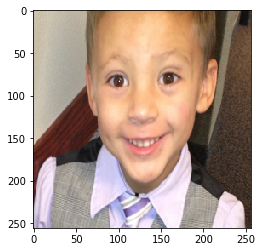

In [50]:
import matplotlib.pyplot as plt
plt.imshow(test_images[index])
print([test_labels[index]])

In [73]:
import numpy as np
y = np.array(y_predict)
y = np.unique(y)

array([0.044061  , 0.04502423, 0.0513963 , 0.05309394, 0.09795763,
       0.1039804 , 0.11203967, 0.11407509, 0.12966135, 0.1299688 ,
       0.13005386, 0.13913581, 0.14203358, 0.14477992, 0.27539802,
       0.28734037], dtype=float32)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [78]:
len(y_predict)

3676

In [8]:
test_df = pd.read_csv("test_faces_concactenated_data_with_path_with_age_range.csv")
test_images = np.array([read_and_resize(file_path) for file_path in test_df.path.values])

In [15]:
dict_age = {'(0, 2)' : 0,
                '(4, 6)' : 1,
                '(8, 12)' : 2,
                '(15, 20)' : 3,
                '(25, 32)' : 4,
                '(38, 43)' : 5,
                '(48, 53)' : 6,
                '(60, 100)' : 7}

test_labels = np.array([dict_age[a] for a in test_df.age.values])

In [10]:
from numpy import save, load

In [14]:
save("test_images_np.npy",test_images)

In [17]:
save("test_labels_np.npy",test_labels)

In [45]:
test_labels[4]

1

In [53]:
count = 0
for i in y_predict:
    if i < 0.5:
        count+=1

In [54]:
count

3670